In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [3]:
path = "/data/OWN/paramstest/e01_t20/output_00041"
mochima= wkbl.Galaxy_Hound(path)
print "loaded"
mochima.r_virial(600)
print "cutted"
nucenter = nbe.real_center(mochima.dm.pos3d, mochima.dm.mass)
mochima.center_shift(nucenter)
mochima.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded
| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,19, 0|
|    | 0, 0, 1|
cutted


In [5]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = mochima.dm.mass
        radii = mochima.dm.r
    elif comp=="st":
        m = mochima.st.mass
        radii = mochima.st.r
    elif comp=="gs":
        m = mochima.gs.mass
        radii = mochima.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(mochima.p.G * enclosed_m / r) * mochima.p.kpctokm



pos_dm = np.array(mochima.dm.pos3d.reshape(len(mochima.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(mochima.gs.pos3d.reshape(len(mochima.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(mochima.st.pos3d.reshape(len(mochima.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((mochima.dm.mass,mochima.st.mass,mochima.gs.mass))
v = np.concatenate((mochima.dm.v,mochima.st.v,mochima.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (mochima.st.R>r[i])&(mochima.st.R<r[i+1])&(np.abs(mochima.st.pos3d[:,2])<0.5)
    gas_condition = (mochima.gs.R>r[i])&(mochima.gs.R<r[i+1])&(np.abs(mochima.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(mochima.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(mochima.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(mochima.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(mochima.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

23123172 23123172


<IPython.core.display.Javascript object>


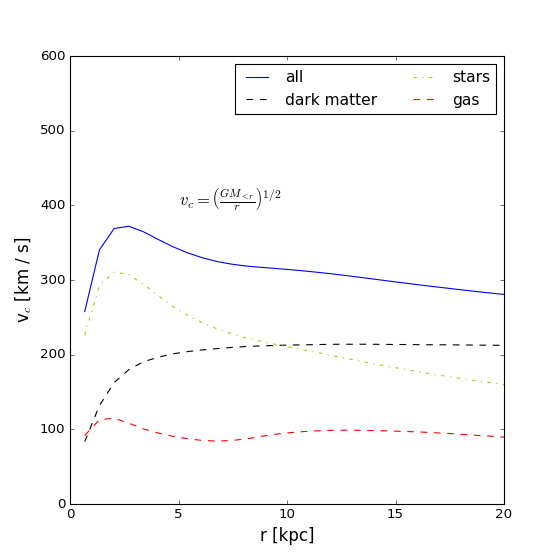

In [11]:
fig, ax = plt.subplots(figsize=[7,7])
ax.set_ylim(0,600)
ax.set_xlim(0,20)
#ax1.set_xlim(0,20)



vc_mochima = vc_all
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()


In [10]:
path = "/data/OWN/SF1test/AnH3/output_00041"
adicora= wkbl.Galaxy_Hound(path)
print "loaded"
adicora.r_virial(600)
print "cutted"
nucenter = nbe.real_center(adicora.dm.pos3d, adicora.dm.mass)
adicora.center_shift(nucenter)
adicora.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded
| r_200 = 224.4140625
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.330e+12 M_sun
| p_dm_200      =  8.558e+05 particles
| stellar mass  =  1.390e+11 M_sun
| p_st_200      =  4.925e+06 psrticles
| gas mass      =  1.084e+11 M_sun
| p_gs_200      =  1.951e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |16, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 3|
cutted


In [12]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = adicora.dm.mass
        radii = adicora.dm.r
    elif comp=="st":
        m = adicora.st.mass
        radii = adicora.st.r
    elif comp=="gs":
        m = adicora.gs.mass
        radii = adicora.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(adicora.p.G * enclosed_m / r) * adicora.p.kpctokm



pos_dm = np.array(adicora.dm.pos3d.reshape(len(adicora.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(adicora.gs.pos3d.reshape(len(adicora.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(adicora.st.pos3d.reshape(len(adicora.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((adicora.dm.mass,adicora.st.mass,adicora.gs.mass))
v = np.concatenate((adicora.dm.v,adicora.st.v,adicora.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (adicora.st.R>r[i])&(adicora.st.R<r[i+1])&(np.abs(adicora.st.pos3d[:,2])<0.5)
    gas_condition = (adicora.gs.R>r[i])&(adicora.gs.R<r[i+1])&(np.abs(adicora.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(adicora.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(adicora.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(adicora.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(adicora.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

23194788 23194788


<IPython.core.display.Javascript object>


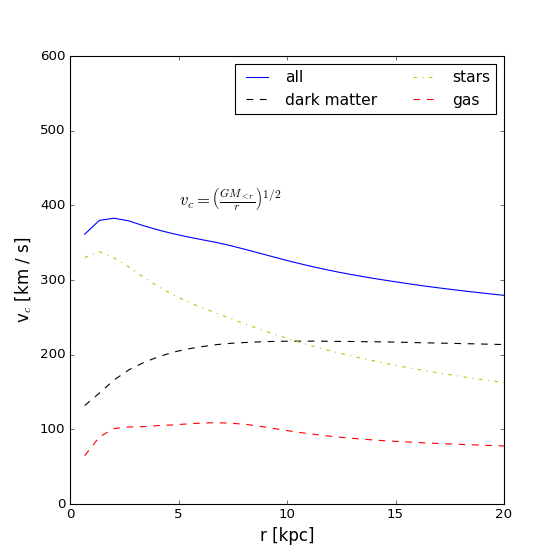

In [14]:
fig, ax = plt.subplots(figsize=[7,7])
ax.set_ylim(0,600)
ax.set_xlim(0,20)
#ax1.set_xlim(0,20)



vc_adicora = vc_all
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()

In [18]:
path = "/data/POL/HALOB/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)
myhalo.r_virial(600)

loading Dark matter..
loading Stars..
loading Gas..
density [ 9685.31347656  9883.21972656  9817.79785156]
starting
stackted
start histogram
 done
rotated
| r_200 = 166.9921875
| Diagonal matrix computed 
|    |19, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 2|


In [19]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = myhalo.dm.mass
        radii = myhalo.dm.r
    elif comp=="st":
        m = myhalo.st.mass
        radii = myhalo.st.r
    elif comp=="gs":
        m = myhalo.gs.mass
        radii = myhalo.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(myhalo.p.G * enclosed_m / r) * myhalo.p.kpctokm



pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (myhalo.st.R>r[i])&(myhalo.st.R<r[i+1])&(np.abs(myhalo.st.pos3d[:,2])<0.5)
    gas_condition = (myhalo.gs.R>r[i])&(myhalo.gs.R<r[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(myhalo.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(myhalo.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(myhalo.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(myhalo.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

33410241 33410241


<IPython.core.display.Javascript object>


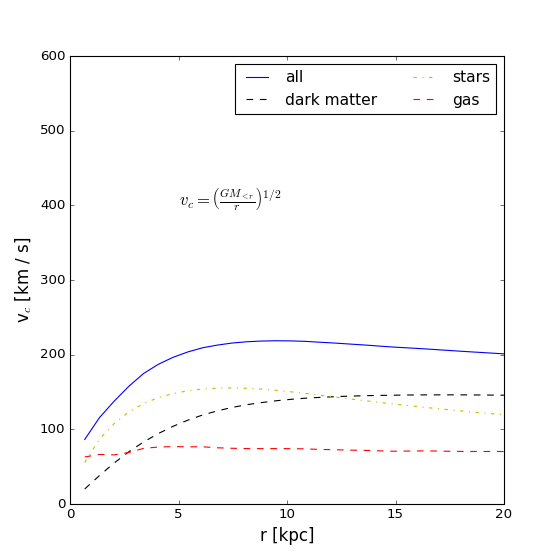

In [20]:
fig, ax = plt.subplots(figsize=[7,7])
ax.set_ylim(0,600)
ax.set_xlim(0,20)
#ax1.set_xlim(0,20)



vc_halob = vc_all
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>


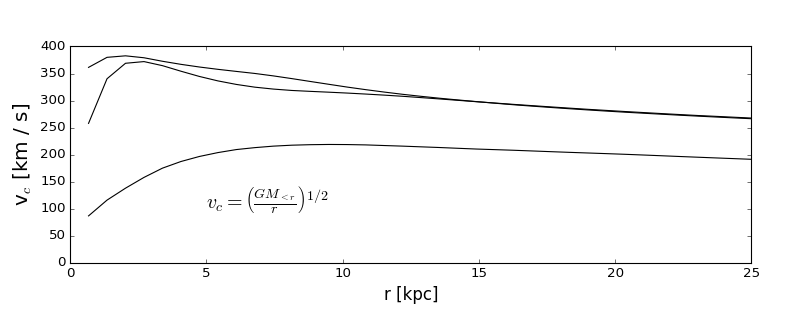

In [35]:
fig, ax = plt.subplots(figsize=[10,4])
ax.set_ylim(0,400)
ax.set_xlim(0,25)
#ax1.set_xlim(0,20)

fig.tight_layout(pad=3)

ax.plot(r, vc_mochima,'k-',label='all')
ax.plot(r, vc_adicora,'k-',label='all')
ax.plot(r, vc_halob,'k-',label='all')

texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,100,texto,fontsize=18)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=18)
